In [119]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import json
import pandas as pd

import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.time_measurement as time_measurement
from lib.ext.baycon.common.DataAnalyzer import *
from lib.ext.baycon.common.Target import Target
from lib.ext.baycon.common.ScoreCalculator import ScoreCalculator
from lib.score_calculator_kmeans import ScoreCalculatorKmeans

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: >

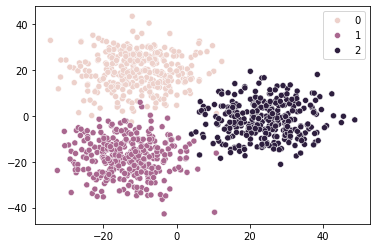

In [120]:
X, y = make_blobs(centers=3, cluster_std=8, n_features=20, n_samples=1000)

pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

In [121]:
clustering = True
if clustering:
    model = KMeans(n_clusters=3)
else:
    model = RandomForestClassifier()
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

/home/jacob/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,label
0,5.942264,-11.259137,7.650530,4.733530,6.188094,-12.070510,-5.570256,24.633759,4.187858,14.001408,...,-18.929755,15.687941,-8.192142,-12.482148,9.743908,20.423207,9.356001,-3.954048,13.519453,2.0
1,-23.711404,-18.822900,3.412126,-1.990553,7.036473,6.632883,-11.374544,4.867287,10.168987,-2.021863,...,8.306380,-4.762095,14.924565,-0.292518,2.460307,-8.772836,3.282030,4.750735,-8.429782,1.0
2,5.543493,5.500765,12.160549,3.796137,8.453907,18.029109,5.178122,-1.223908,6.688660,8.636610,...,16.749419,1.203987,-0.748519,3.975614,16.227931,-7.159438,8.509613,10.110454,3.270050,0.0
3,2.414916,-1.912981,6.545500,13.745144,17.831215,10.176049,-7.518030,13.442530,1.818630,-14.417229,...,6.665929,9.609070,-6.276824,2.642788,1.711278,-9.792709,8.860348,3.771160,-1.074520,1.0
4,-6.054045,-17.090169,7.592667,-16.859909,8.142406,-9.488711,-5.912698,11.116687,12.906624,15.053137,...,-27.988102,12.256730,19.589894,-8.592507,8.836968,10.155427,-10.963039,8.775606,10.623596,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-5.790984,-3.131959,0.236343,-1.559308,5.250165,-4.451944,1.565078,10.795391,11.487409,3.409527,...,31.303191,6.169369,-3.126518,-6.680053,3.162951,0.586582,0.778146,4.835836,-3.563705,1.0
996,-3.389697,6.237140,-7.134838,-7.983792,1.393551,-14.855999,-1.474116,7.161019,3.991934,-8.536441,...,9.671084,-7.059744,1.559737,5.426082,-8.068754,-22.605715,5.226591,-2.910489,4.555741,1.0
997,-4.156341,-7.067292,8.341221,12.706894,4.468131,-12.646659,-2.416201,5.625341,-6.658092,2.370177,...,-1.927277,15.786938,11.670580,-13.346688,11.879823,-0.970181,-9.373937,9.531660,-11.421809,1.0
998,-2.951164,-9.962745,2.993033,1.289402,3.246307,4.962161,-8.035647,-9.587528,-5.739055,-12.212088,...,20.288482,4.830932,11.989955,-1.011156,-15.410454,-18.489585,3.466053,23.866236,-6.212018,1.0


<Axes: >

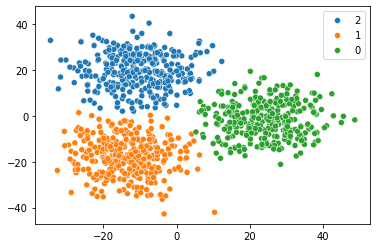

In [122]:
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=pred)

In [123]:
def execute(df, model, target, initial_instance_index, categorical_features=[], actionable_features=[]):
    y = df[[target.target_feature()]].values.ravel()
    X = df.drop([target.target_feature()], axis=1).values
    feature_names = df.columns[df.columns != target.target_feature()]

    run = 0
    data_analyzer = DataAnalyzer(X, y, feature_names, target, categorical_features, actionable_features)
    X, y = data_analyzer.data()
    initial_instance = X[initial_instance_index]
    initial_prediction = y[initial_instance_index]

    print("--- Executing... Initial Instance: {} Target: {} Run: {} ---".format(
        initial_instance_index,
        target.target_value_as_string(),
        run
    ))


    # Initialize ScoreCalculator Classification / Clustering
    initial_instance_f = initial_instance.astype(float)   # np operations need same type object to compute!
    if target.target_type() == Target.TYPE_CLASSIFICATION or target.target_type() == Target.TYPE_REGRESSION:
        score_calculator = ScoreCalculator(initial_instance, initial_prediction, target, data_analyzer)
        target_cluster_center = None
        min_target_cluster_distance = None
        max_target_cluster_distance = None
    elif target.target_type() == Target.TYPE_CLUSTERING_KMEANS:
        # point_pred = int(model.predict([X[initial_instance_index]])[0])
        target_cluster_center = model.cluster_centers_[target._target_value]
        
        target_cluster_indices = np.where(y == target._target_value)

        min_target_cluster_distance = np.min([np.linalg.norm(i-target_cluster_center) for i in X[target_cluster_indices]])
        max_target_cluster_distance = np.max([np.linalg.norm(i-target_cluster_center) for i in X[target_cluster_indices]])
        # max_target_cluster_distance = np.max([np.linalg.norm(i-target_cluster_center) for i in X])

        base_calculator = ScoreCalculator(initial_instance, initial_prediction, target, data_analyzer)
        score_calculator = ScoreCalculatorKmeans(initial_instance, initial_prediction, target, data_analyzer, base_calculator, min_target_cluster_distance, max_target_cluster_distance, target_cluster_center)

    counterfactuals, _ranker = baycon.run(initial_instance_f, initial_prediction, target, data_analyzer, model, score_calculator)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    # output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
    #                                                   target.target_value_as_string(), model_name, run)
    # with open(output_filename, 'w') as outfile:
    #     json.dump(output, outfile)
    # print("--- Finished: saved file {}\n".format(output_filename))
    
    return counterfactuals, predictions, initial_instance, initial_prediction, target_cluster_center, min_target_cluster_distance, max_target_cluster_distance #, data_analyzer, ranker, model


In [128]:
point_idx = 0
point_pred = int(model.predict([X[point_idx]])[0])
print("Point prediction: ", point_pred, type(point_pred))
if clustering:
    t = Target(target_type="clustering_kmeans", target_feature="label", target_value=1)
else:
    t = Target(target_type="classification", target_feature="label", target_value=1)

cf, _predictions, _initial_instance, _initial_prediction, target_center, min_center_dist, max_center_dist = execute(df, model, t, point_idx)

Point prediction:  2 <class 'int'>
--- Executing... Initial Instance: 0 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (661) CFs (0)
Re-training surrogate model with data size: 661
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (1) Unique overall (1)
Generated random instances: (3232)
Predicted top: 20 Counterfactuals: 0
Found new best [  5.94226381 -11.25913676   7.65053044   4.73352993  -3.12208442
 -12.0705102   -5.5702563   -6.77045154   5.81806015 -13.92097021
   7.33191727 -18.92975524  15.68794118  -8.19214217 -12.48214782
   9.74390773 -15.72795408   9.35600112  -3.95404815  13.51945298], with fitness score 0.0331 (X 0.83612 Y 0.05274 F 0.75), oversampling
Known alternatives: 681
Best instance score 0.0331 (X 0.83612 Y 0.05274 F 0.75), found on epoch: 1
Re-training surrogate model with data size: 691
--- epoch 2 ----


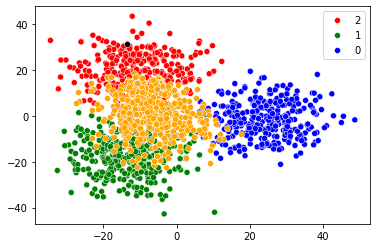

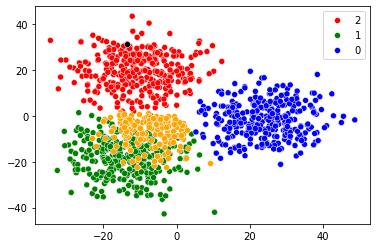

In [130]:

embed_cf = pca.transform(cf)
sns.scatterplot(x=embed_X[:,0], y=embed_X[:,1], hue=pred, palette=['red','green','blue'])
sns.scatterplot(x=embed_cf[:,0], y=embed_cf[:,1], color='orange')
sns.scatterplot(x=embed_X[[0],0], y=embed_X[[0],1], color='black')
plt.show()

filtered_cfs = [i for i in cf if model.predict(i.reshape(1,-1)) == t._target_value]
embed_cf = pca.transform(filtered_cfs)
sns.scatterplot(x=embed_X[:,0], y=embed_X[:,1], hue=pred, palette=['red','green','blue'])
sns.scatterplot(x=embed_cf[:,0], y=embed_cf[:,1], color='orange')
sns.scatterplot(x=embed_X[[0],0], y=embed_X[[0],1], color='black')
plt.show()

if clustering:
    center_distances = [np.linalg.norm(i-target_center) for i in cf]
    y_score = 1 - ((center_distances - min_center_dist)/(max_center_dist - min_center_dist))
    y_score[y_score < 0] = 0
    y_score[y_score > 1] = 1
    print(y_score)